<a href="https://colab.research.google.com/github/mdeleond/Portfolio/blob/main/Projects/Montevideo%20Traffic%20accidents%20analysis/Siniestros_en_Montevideo_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Traffic accidents in Montevideo



#1.- Introduction
In this case, we'll be analyzing the Montevideo traffic accidents dataset for 2024. Each record is an accident with the features related to it (date, hour, day of week, category, severity and geographical coordinates), as will be seen on next chapter.

#2.- Data sets
We are going to use 3 data sets to assess the driver's behavior:


*   **The accidents dataset (1)**, to know the number and nature of siniestrality.
*   **The weather dataset(2)**, to link the accidents with weather features.
*   **The football matches dataset(3)**, to evaluate the impact of football matches on driver's psyque.
##2.1.- Source
  *   (1) is available publicly at [Geoportal de UNASEV](https://aplicacionesunasev.presidencia.gub.uy/mapas/AdministracionMapaIndicadores/AdministracionMapaIndicadores_Alta) (data repo of Office of National Road Safety, UNASEV)

  *   (2) is available publicly at the [Banco Agrometeorológico del INIA](https://www.inia.uy/gras/Clima/Banco-datos-agroclimatico) (Instituto de Investigación Agropecuaria, INIA)

  *   (3) we obtained scrapping from the AUF page



#3.- Setup and library imports

In [ ]:
from google.colab import drive
from google.colab import userdata
route = userdata.get('proj_route')
drive.mount('/content/drive')
%cd -q {route}

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

#4.-Functions
Here we'll define all the functions needed to help getting the insights (ETL, tasks, etc.)


In [ ]:
"""This function checks every column on a given dataframe and removes the spaces at the start and end of each value.
"""
def remove_whitespace(y):
  for name in y.columns:
    if name != 'geometry':
      y[name] = y[name].apply(lambda value: str(value).strip())
  return y

In [ ]:
#Define some dictionaires to convert es-en weekday words
order = ['LUNES','MARTES','MIÉRCOLES','JUEVES','VIERNES','SÁBADO','DOMINGO']
order_en = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
order_dict = dict(zip(order,order_en))

#5.- Exploratory analysis
Now we'll try to open the .txt file containing the car accidents.

In [ ]:
with open('accidents_2024_mvd.txt', "r") as file:
    lines = file.readlines()
    first_line = lines[0]
    second_line = lines[1]
    third_line = lines[2]
    print(first_line)
    print(second_line,third_line)

Fecha, Calle, Tipo de Siniestro, Gravedad, Dia Semana, Hora, Departamento, Localidad, fixed, X, Y 

30/5/2024,, CAMINO AL PASO DEL ANDALUZ, COLISIÓN ENTRE VEHÍCULOS, LEVE, JUEVES, 17, MONTEVIDEO, MONTEVIDEO, 1, 578310, 6148715 
 1/8/2024,, MIGUELETE, COLISIÓN ENTRE VEHÍCULOS, GRAVE, JUEVES, 20, MONTEVIDEO, MONTEVIDEO, 1, 574765, 6138210 



Detected the file contained a double colon (,,) at some parts.

This is an issue as the colon is the separator which gives us the table structure, so it's necessary to remove them before passing it into a dataframe.

In [ ]:
reading_file = open('accidents_2024_mvd.txt', "r")
new_file_content = "" #We create an empty string to store the file content

for line in reading_file:
    stripped_line = line.strip()
    new_line = stripped_line.replace(",,", ",") # At every line, we check if there's a double colon and replace it by a single colon to fix the structure
    new_file_content += new_line +"\n"
reading_file.close()

writing_file = open('accidents_ok.txt', "w") # store the fixed file
writing_file.write(new_file_content)

writing_file.close()

In [ ]:
accidents = pd.read_csv('accidents_ok.txt', sep=",",index_col=False)
cols = list(accidents.columns)
cols = [col.strip().replace(' ', '_') for col in cols]
accidents.columns = cols
accidents = remove_whitespace(accidents) # to make sure there are no values with spaces at start or end (function defined on chapter 4)
accidents

,Fecha,Calle,Tipo_de_Siniestro,Gravedad,Dia_Semana,Hora,Departamento,Localidad,fixed,X,Y
0,30/5/2024,CAMINO AL PASO DEL ANDALUZ,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,17,MONTEVIDEO,MONTEVIDEO,1,578310,6148715
1,1/8/2024,MIGUELETE,COLISIÓN ENTRE VEHÍCULOS,GRAVE,JUEVES,20,MONTEVIDEO,MONTEVIDEO,1,574765,6138210
2,10/4/2024,AVENIDA ITALIA,CAÍDA,LEVE,MIÉRCOLES,17,MONTEVIDEO,MONTEVIDEO,1,577155,6138700
3,27/3/2024,SIN DATOS,COLISIÓN ENTRE VEHÍCULOS,SIN LESIONADOS,MIÉRCOLES,22,MONTEVIDEO,SIN DATOS,1,560055,6147080
4,1/6/2024,AVENIDA DE LAS INSTRUCCIONES,COLISIÓN ENTRE VEHÍCULOS,LEVE,SÁBADO,14,MONTEVIDEO,MONTEVIDEO,1,573330,6144220
...,...,...,...,...,...,...,...,...,...,...,...
8414,19/4/2024,AVENIDA DOCTOR AMERICO RICALDONI,COLISIÓN ENTRE VEHÍCULOS,LEVE,VIERNES,15,MONTEVIDEO,MONTEVIDEO,1,577585,6138140
8415,20/7/2024,AVENIDA DOCTOR CARLOS MARIA RODRIGUEZ,DESPISTE,SIN LESIONADOS,SÁBADO,17,MONTEVIDEO,MONTEVIDEO,1,569295,6141050
8416,8/3/2024,CAMINO CARRASCO,COLISIÓN ENTRE VEHÍCULOS,LEVE,VIERNES,8,MONTEVIDEO,MONTEVIDEO,1,585580,6141180
8417,29/9/2024,CAMINO CORRALES,COLISIÓN ENTRE VEHÍCULOS,LEVE,DOMINGO,23,MONTEVIDEO,MONTEVIDEO,1,577310,6143570


In [ ]:
#search for duplicated rows
accidents[accidents.duplicated()==True]

,Fecha,Calle,Tipo_de_Siniestro,Gravedad,Dia_Semana,Hora,Departamento,Localidad,fixed,X,Y
1786,3/6/2024,AVENIDA JOSE BELLONI,ATROPELLO DE PEATÓN,LEVE,LUNES,15,MONTEVIDEO,MONTEVIDEO,1,578575,6146110
1875,8/4/2024,LUIS ENRIQUE AZAROLA GIL,COLISIÓN ENTRE VEHÍCULOS,LEVE,LUNES,12,MONTEVIDEO,MONTEVIDEO,1,577595,6146935
2096,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
3110,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
3905,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
4064,11/12/2024,AVENIDA ITALIA,COLISIÓN ENTRE VEHÍCULOS,SIN LESIONADOS,MIÉRCOLES,9,MONTEVIDEO,MONTEVIDEO,1,576510,6138400
4198,15/3/2024,AVENIDA DE LAS LEYES,CAÍDA,LEVE,VIERNES,5,MONTEVIDEO,MONTEVIDEO,1,574220,6138850
4954,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
5019,8/4/2024,AVENIDA OCHO DE OCTUBRE,COLISIÓN ENTRE VEHÍCULOS,LEVE,LUNES,14,MONTEVIDEO,MONTEVIDEO,1,578905,6140720
5084,21/7/2024,CAMINO CARRASCO,COLISIÓN ENTRE VEHÍCULOS,LEVE,DOMINGO,12,MONTEVIDEO,MONTEVIDEO,1,585545,6141165


##5.1.- Data preparation

In [ ]:
accidents.drop_duplicates(inplace=True)

In [ ]:
accidents.info()
accidents.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 8398 entries, 0 to 8418
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              8398 non-null   object
 1   Calle              8398 non-null   object
 2   Tipo_de_Siniestro  8398 non-null   object
 3   Gravedad           8398 non-null   object
 4   Dia_Semana         8398 non-null   object
 5   Hora               8398 non-null   object
 6   Departamento       8398 non-null   object
 7   Localidad          8398 non-null   object
 8   fixed              8398 non-null   object
 9   X                  8398 non-null   object
 10  Y                  8398 non-null   object
dtypes: object(11)
memory usage: 787.3+ KB


,0
Fecha,object
Calle,object
Tipo_de_Siniestro,object
Gravedad,object
Dia_Semana,object
Hora,object
Departamento,object
Localidad,object
fixed,object
X,object


In [ ]:
#Change dtypes to match every column values
accidents = accidents.astype({'Fecha':'datetime64[ns]',
                              'Hora':'int',
                              'fixed':'int',
                              'X':'int',
                              'Y':'int'})

In [ ]:
accidents.dtypes

,0
Fecha,datetime64[ns]
Calle,object
Tipo_de_Siniestro,object
Gravedad,object
Dia_Semana,object
Hora,int64
Departamento,object
Localidad,object
fixed,int64
X,int64


Let's start looking at the values on several columns, starting by the categorical ones:

In [ ]:
accidents.Dia_Semana.unique(), accidents.Tipo_de_Siniestro.unique(), accidents.Gravedad.unique(), accidents.Localidad.unique()

(array(['JUEVES', 'MIÉRCOLES', 'SÁBADO', 'LUNES', 'MARTES', 'DOMINGO',
        'VIERNES'], dtype=object),
 array(['COLISIÓN ENTRE VEHÍCULOS', 'CAÍDA', 'DESPISTE',
        'ATROPELLO DE PEATÓN', 'ATROPELLO DE ANIMALES',
        'COLISIÓN CON OBSTÁCULO EN CALZADA'], dtype=object),
 array(['LEVE', 'GRAVE', 'SIN LESIONADOS', 'FATAL'], dtype=object),
 array(['MONTEVIDEO', 'SIN DATOS'], dtype=object))

Everything seems reasonable, maybe should check the Localidad column with values 'SIN DATOS' (no data)

In [ ]:
accidents.Fecha.nunique() #if complete, there will be 366 distinct values (2024 was a leap year)

366

Which seems right too. Let's explore how the records are distributed on each feature:

In [ ]:
accidents.Gravedad.value_counts()

,count
Gravedad,
LEVE,5936
SIN LESIONADOS,1314
GRAVE,1049
FATAL,99


Severity has 4 categories:
* No injured
* Shallow
* Severe
* Fatal



In [ ]:
accidents.Dia_Semana.value_counts()

,count
Dia_Semana,
VIERNES,1322
MARTES,1292
MIÉRCOLES,1288
JUEVES,1287
LUNES,1252
SÁBADO,1059
DOMINGO,898


Fridays are the day with most accidents, and Sundays have the least accident records

In [ ]:
accidents.Tipo_de_Siniestro.value_counts()

,count
Tipo_de_Siniestro,
COLISIÓN ENTRE VEHÍCULOS,6044
ATROPELLO DE PEATÓN,916
CAÍDA,732
DESPISTE,420
COLISIÓN CON OBSTÁCULO EN CALZADA,182
ATROPELLO DE ANIMALES,104


The most common accident is car crash. It's interesting to see pedestrian casualties being the second most common casualty.

In [ ]:
accidents.Hora.value_counts().sort_values(ascending=False).head(5)

,count
Hora,
17,674
18,660
16,571
15,533
14,510


The time when most accidents occur are between 14:00-18:00, with 17:00 being the most crowded with accidents.

In [ ]:
accidents['Mes'] = accidents['Fecha'].dt.month_name()
monthly_accidents = accidents.Mes.value_counts().reset_index()
monthly_accidents

,Mes,count
0,September,764
1,October,762
2,June,762
3,November,754
4,May,746
5,August,716
6,December,714
7,April,709
8,July,678
9,March,625


September is the month when most accidents occurred. October and June follow closely with 762 accidents each.

In [ ]:
year_2024 = pd.DataFrame(columns=['Date'])
year_2024['Date'] = pd.Series(pd.date_range("1/1/2024", freq="D", periods=366))
year_2024['DoW'] = year_2024['Date'].dt.day_name()
year_2024

,Date,DoW
0,2024-01-01,Monday
1,2024-01-02,Tuesday
2,2024-01-03,Wednesday
3,2024-01-04,Thursday
4,2024-01-05,Friday
...,...,...
361,2024-12-27,Friday
362,2024-12-28,Saturday
363,2024-12-29,Sunday
364,2024-12-30,Monday


In [ ]:
peak_accidents = accidents.groupby(['Dia_Semana','Hora']).agg({'fixed':'sum'}).reset_index() #add all the accidents for each day and hour
accidents_daily = accidents.Dia_Semana.value_counts().reset_index()
accidents_daily['count'] = accidents_daily['count']/len(year_2024[year_2024['DoW'].isin(
    [order_dict[day] for day in accidents_daily['Dia_Semana']])])
accidents_daily

,Dia_Semana,count
0,VIERNES,3.612022
1,MARTES,3.530055
2,MIÉRCOLES,3.519126
3,JUEVES,3.516393
4,LUNES,3.420765
5,SÁBADO,2.893443
6,DOMINGO,2.453552


In [ ]:


peak_accidents['fixed'] = peak_accidents['fixed']/len(year_2024[year_2024['DoW'].isin(
    [order_dict[day] for day in peak_accidents['Dia_Semana']])]) #compute the mean of accidents distributed along every day of the week and hour

peak_accidents.sort_values(by='fixed',ascending=False).head(12)

,Dia_Semana,Hora,fixed
41,JUEVES,17,0.363388
89,MARTES,17,0.349727
90,MARTES,18,0.319672
113,MIÉRCOLES,17,0.311475
42,JUEVES,18,0.306011
114,MIÉRCOLES,18,0.292350
162,VIERNES,18,0.284153
66,LUNES,18,0.270492
161,VIERNES,17,0.267760
40,JUEVES,16,0.262295


The average accidents per hour concentrates on 17:00-18:00, being

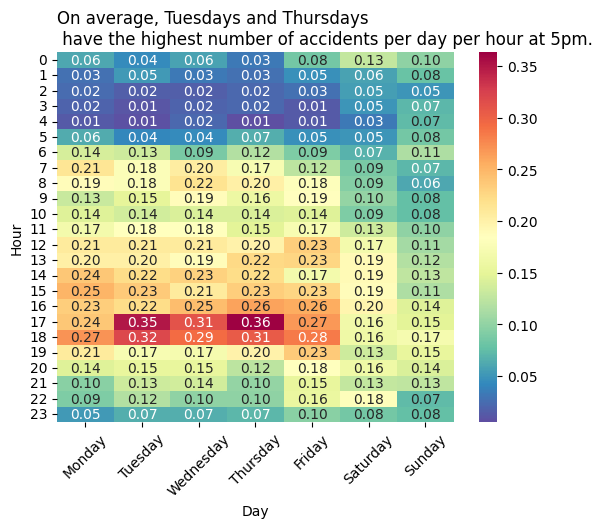

In [ ]:
acc_by_time = pd.pivot_table(peak_accidents, values='fixed', index=['Hora'],columns=['Dia_Semana'])
acc_by_time = acc_by_time[order]
acc_by_time.rename(columns=order_dict, inplace=True)

fig, ax = plt.subplots()
sns.heatmap(acc_by_time, annot=True, fmt='1.2f',robust=False,cmap="Spectral_r")
plt.title('On average, Tuesdays and Thursdays \n have the highest number of accidents per day per hour at 5pm.',loc='left',fontweight="light")
ax.set(xlabel="Day", ylabel="Hour")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()